**This notebook trains CIFAR 10 with resnet18 architecture using cyclic learning rates**

Note on utility files:


1.   resnet.py - the utility functions to build a ResNet18 architecture. Below i have explained the strategy
2.   clr.py - classes to be used for LR finder and OneCyclePolicy
3.   image_augmentation_utils.py - the wrapper function that wraps augmentations of padding and cropping, normalizing using imagenet std dev and mean and cutout.



**ResNet18 architecture and stride strategy** is as follows:

 

*   Replace 7 x 7/ stride 2 with 3- 3 x 3/ stride 1 conv layers. 


> Using 3 x 3 - 3 times is equivalent to a single 7 x 7, yet it has less parameters. 

> Changing the stride to 1 helps overcome checkerboard issue, also maintains the resolution of channels so that in last layers we dont end up with just one pixel output

*   This is followed by a Maxpool(3 x 3 / stride 2). After 7 x 7 I expect the kernels to have figured out textures/patterns. Hence a good time to use maxpool

*   Instead of having strides every 2 layer, I have followed -> [3,3,2] where each comma indicates before the first conv layer that follows we have a maxpool layer of (3 x 3/ stride 2)
*   Basically there are **no 2 strided convolutions, instead I have used 3 Maxpool layers**
*   Weight decay of 1e-4 is used. Using 5e-4 resulted in slow learning






> This is because, having too many strided layers were reducing the resolution of images. Besides, just 2 resnet blocks might not have much mature patters on which we can combine pixels.

**Output Summary:**

 Was able to train the architecture to ***90% in 34th epoch***. 
 
 Running it till 50 gave accuracy of 92.23%
 
 With test time augmentation accuracy shot up to 94.1%.
 
 With 150 epochs, i got 93.89% and with tta, 95.25%



In [3]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/' #change dir to your project folder

os.chdir('/content/' + root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from clr import LR_Finder,OneCycleLR

from image_augmentation_utils import get_custom_augmentations

import resnet

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.layers import GlobalAveragePooling2D

from keras import optimizers

from keras import regularizers

from keras.callbacks import Callback

import cv2

from sklearn.metrics import accuracy_score

import numpy as np

import warnings

warnings.filterwarnings("ignore")



In [5]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


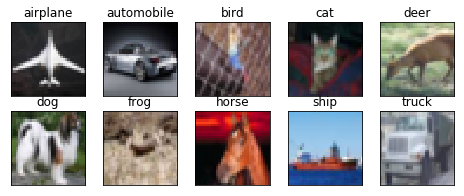

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
train_labels_integer = train_labels

test_labels_integer = test_labels

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels_integer[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(iterator, model):
    
    accuracy = model.evaluate_generator(iterator, steps=len(iterator))[1]
    return (accuracy * 100)
  
def tta_preds(img, model, data_gen, num_aug_images):
  
  img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
  
  images = data_gen.flow(img, batch_size=num_aug_images)
  
  predictions = model.predict_generator(images, steps=num_aug_images)
  
  prediction_mean = np.mean(predictions, axis=0)
  
  return np.argmax(prediction_mean)


def tta_accuracy(model, X, Y, data_gen, num_aug_images=5):
  
  yhats=[]
  
  for i in range(len(X)):
      
        yhat = tta_preds(X[i], model, data_gen, num_aug_images)

        yhats.append(yhat)
    
  testY_labels = np.argmax(Y, axis=1)
    
  acc = accuracy_score(testY_labels, yhats)
    
  return acc

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

**Setting up DataAugmentation**

In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                             #featurewise_center=True,featurewise_std_normalization=True,
                            preprocessing_function=get_custom_augmentations(v_l=0, v_h=1, normalize = True, random_crop = True, cutout = True)
                            )


datagen.fit(train_features)

datagen_test = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True,
                                  #featurewise_center=True,featurewise_std_normalization=True,
                            preprocessing_function=get_custom_augmentations(v_l=0, v_h=1, normalize = True, random_crop = False, cutout = False)
                            )


datagen_test.fit(test_features)



iterator = datagen.flow(train_features, train_labels, batch_size = train_features.shape[0])

X_train_da, y_train_da = iterator.next()

iterator_test = datagen_test.flow(test_features, test_labels, batch_size = test_features.shape[0], shuffle = True)

X_test_da, y_test_da = iterator_test.next()

**Visualizing augmented images**

W0731 00:41:54.450100 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:54.453158 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:54.455991 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:54.461499 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:54.464812 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:54.468509 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:54.472505 140491

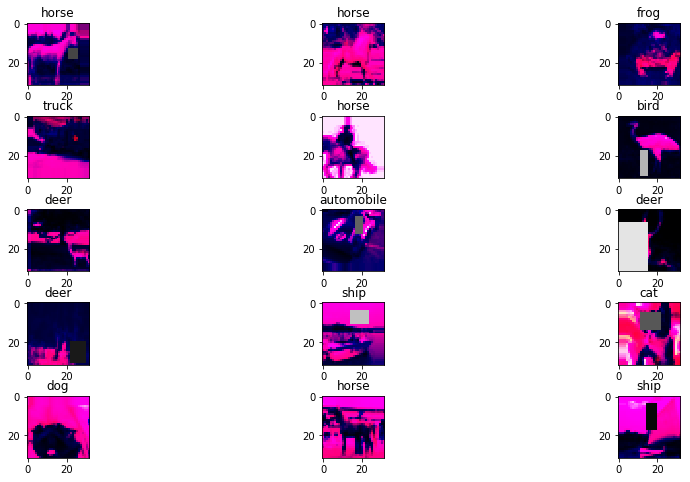

In [11]:
def show_random_imgs(im_list, label_list,num_imgs_to_show = 15):
  
  import random

  random_images_tolook = [random.randint(0,im_list.shape[0]) for x in range(num_imgs_to_show)]

  actual_y = np.argmax(label_list, axis=1)

  fig, axeslist = plt.subplots(ncols = 3, nrows = len(random_images_tolook)//3 , figsize=(15,8))

  for ind in range(len(random_images_tolook)):

    axeslist.ravel()[ind].imshow(im_list[random_images_tolook[ind]])

    axeslist.ravel()[ind].set_title(class_names[actual_y[random_images_tolook[ind]]])

  plt.subplots_adjust(hspace = 0.5)
  
show_random_imgs(X_train_da, y_train_da)

W0731 00:41:56.178141 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:56.180760 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:56.183777 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:56.189059 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:56.193473 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:56.197339 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 00:41:56.201566 140491

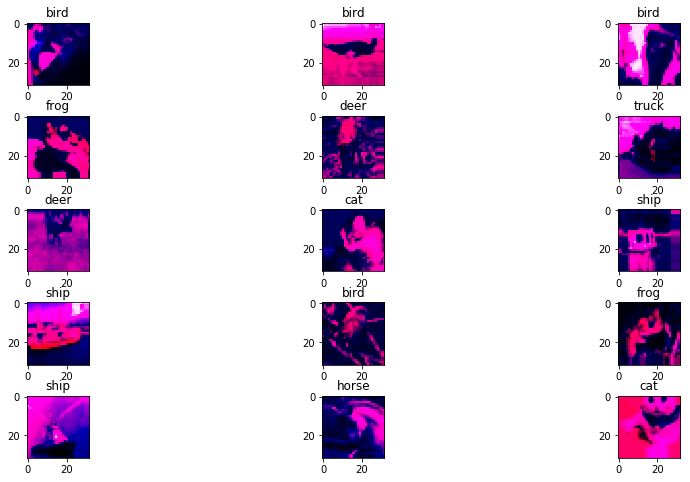

In [12]:
show_random_imgs(X_test_da, y_test_da)

In [13]:
# Define the model

model = resnet.ResNet18((train_features.shape[1], train_features.shape[2], train_features.shape[3]), 10)

model.summary()

W0731 00:41:57.793217 140491429029760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 00:41:57.843132 140491429029760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 00:41:57.850977 140491429029760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0731 00:41:57.907210 140491429029760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0731 00:41:57.908221

reshaping via a convolution...
reshaping via a convolution...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________

W0731 00:42:03.636661 140491429029760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 00:42:04.120338 140491429029760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model took 59.43 seconds to train


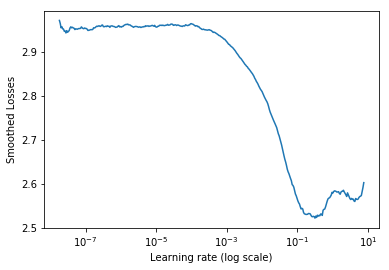

In [14]:
# Compile the model

sgd = optimizers.SGD(lr=0.01,  momentum=0.9)


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model

bs = int(128)


step_size_clr = int(train_features.shape[0])//bs

lr_finder = LR_Finder(start_lr=1e-8, end_lr=10, step_size=step_size_clr)

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], 
                                 callbacks=[lr_finder] ,verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

#lr_finder.plot_schedule()
lr_finder.plot_smoothed_loss()

**Setting up the learning rate and callbacks**

In [0]:
epochs = 50
max_lr = 0.08
base_lr = 0.01
max_m = 0.95
base_m = 0.85
end_percentage = 0.3

cyclical_momentum = True

decayrate = base_lr/epochs

lr_manager = OneCycleLR( max_lr = max_lr, batch_size = bs, samples = train_features.shape[0],
                        end_percentage=end_percentage, scale_percentage=None,
                        maximum_momentum=max_m, minimum_momentum=base_m)

filepath = "assignment_13_no2stride_eva.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

sgd = optimizers.SGD(lr=base_lr,  momentum=0.9, decay=decayrate)

class showLR( Callback ) :
    
    time = time.time()
    
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
          self.time = time.time()
          
          print("time registered", self.time)
          
        current_time = time.time()
        
        time_taken = current_time - self.time
        lr = float(K.get_value(self.model.optimizer.lr))
        print(" epoch={:02d}, lr={:.5f}, time_elapsed(s)={:.2f}".format( epoch, lr, time_taken))

showlr = showLR()

**Train for 50 epochs with cyclic LR**

10.0
0.01
Epoch 1/50
time registered 1564533823.342399
 epoch=00, lr=0.02400, time_elapsed(s)=0.00
390/390 [==============================] - 59s 152ms/step - loss: 2.5448 - acc: 0.2743 - val_loss: 3.1223 - val_acc: 0.1872

Epoch 00001: val_acc improved from -inf to 0.18720, saving model to assignment_13_no2stride_eva.hdf5
 - lr: 0.06367 - momentum: 0.94 
Epoch 2/50
 epoch=01, lr=0.06377, time_elapsed(s)=65.53
390/390 [==============================] - 56s 144ms/step - loss: 1.9724 - acc: 0.4480 - val_loss: 2.6606 - val_acc: 0.3058

Epoch 00002: val_acc improved from 0.18720 to 0.30580, saving model to assignment_13_no2stride_eva.hdf5
 - lr: 0.10344 - momentum: 0.94 
Epoch 3/50
 epoch=02, lr=0.10354, time_elapsed(s)=122.73
390/390 [==============================] - 56s 144ms/step - loss: 1.6022 - acc: 0.5683 - val_loss: 2.5515 - val_acc: 0.3082

Epoch 00003: val_acc improved from 0.30580 to 0.30820, saving model to assignment_13_no2stride_eva.hdf5
 - lr: 0.14321 - momentum: 0.93 
Epoch

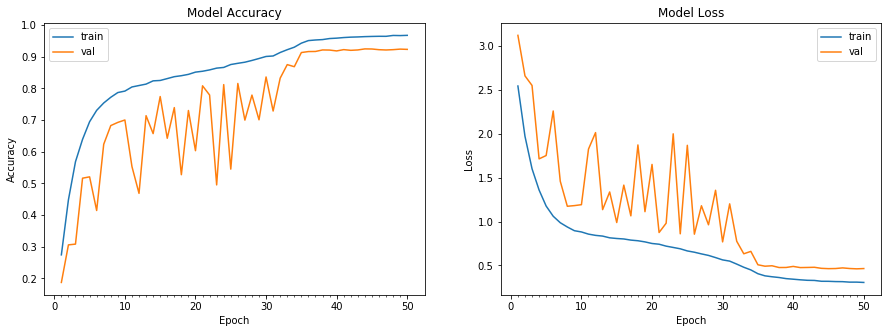

Accuracy on test data is: 92.23


In [16]:
sgd = optimizers.SGD(lr=base_lr,  momentum=0.9, decay=decayrate)


print(K.get_value(model.optimizer.lr))


model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

print(K.get_value(model.optimizer.lr))


# train the model
start = time.time()

test_iterator = datagen_test.flow(test_features, test_labels, batch_size = bs, shuffle = False)

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),
                                 samples_per_epoch = int(train_features.shape[0]), nb_epoch = epochs, 
                                 validation_data = test_iterator,
                                 validation_steps = len(test_iterator),
                                 callbacks=[checkpoint, lr_manager, showlr] ,verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

model.load_weights(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_iterator, model))

**Test time augmentation score**

In [18]:
num_aug_images_tta = 15

tta_acc = tta_accuracy(model, test_features, test_labels,  datagen_test, num_aug_images = num_aug_images_tta)

print("Accuracy on test data using test time augmentation is: %0.2f"%tta_acc)

Accuracy on test data using test time augmentation is: 0.94


# GradCam on mis-classified images

In [0]:
from google.colab.patches import cv2_imshow

from matplotlib import gridspec

from keras.preprocessing.image import img_to_array

import cv2

def get_gradcam(image_in, layer_name = "res5c_branch2c", num_kernels = 2048):
  

  #image_in = cv2.resize(image_in, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

  x = img_to_array(image_in)

  x = x.reshape((1, image_in.shape[0], image_in.shape[1], image_in.shape[2]))

  #x = preprocess_input(x)

  preds = model.predict(x)

  class_idx = np.argmax(preds[0])

  #print(class_idx)

  class_output = model.output[:, class_idx]

  #print(imagenet_classes[class_idx])

  last_conv_layer = model.get_layer(layer_name)

  grads = K.gradients(class_output, last_conv_layer.output)[0]

  #print(grads.shape)

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  #print(pooled_grads.shape)

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(num_kernels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)

  #print(conv_layer_output_value.shape)

  #print(heatmap.shape)

  heatmap = np.maximum(heatmap, 0)

  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (image_in.shape[1], image_in.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(cv2.resize(image_in, dsize=(32, 32), interpolation=cv2.INTER_CUBIC), 0.5, heatmap, 0.5, 0, dtype = cv2.CV_32F)

  #cv2_imshow(image_in)

  #cv2_imshow(heatmap)

  #cv2_imshow(superimposed_img)
  
  return superimposed_img



def get_wrongly_classified_indices(predictions, y_vals):
  
  """
  Takes predicted and actual values
  Returns a tuple of misclassified image indexes and their corresponding predicted and actual values
  
  NOTE: Make sure your predictions are in the same order of actuals, using shuffle=False while predicting would be important
  
  Params:
  predictions: probability values of predictions
  y_vals: actual values of data
  """
  
  predicted_y = np.argmax(predictions, axis=1)
  
  actual_y = np.argmax(y_vals, axis = 1)
  
  wrong_indices = np.nonzero(~(actual_y == predicted_y))
  
  return (wrong_indices[0], predicted_y[wrong_indices[0]], actual_y[wrong_indices[0]])
  
  
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig = plt.figure(figsize=(15,20))
    
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, wspace=0.4, hspace=0, top = 0.5, bottom  = 0)
    
    for ind,title in enumerate(figures):
        
        nested_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[ind], wspace=0) # 1 row, 2 columns for each cluster
        
        ax = plt.Subplot(fig, nested_gs[0])
        
        
        ax.imshow(figures[title]["image"])
        
        fig.add_subplot(ax)
        
        ax.set_title(title)
        
        ax = plt.Subplot(fig, nested_gs[1])        
        
        ax.imshow(figures[title]["grad_cam"])
        
        fig.add_subplot(ax)
        
        
    plt.subplots_adjust(hspace = 0)
    plt.show()    
    


In [20]:
import warnings
warnings.filterwarnings("ignore")

predictions = model.predict(test_features)
    
misclassified_image_idx = get_wrongly_classified_indices(predictions, test_labels)

print(misclassified_image_idx)

number_of_im = len(misclassified_image_idx[0])

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

if (number_of_im) > 25:
  number_of_im = 25

figures = {}

for i in range(number_of_im):
  
  title = str(i+1)+'.\tPredicted: '.expandtabs()+class_names[misclassified_image_idx[1][i]] + '\n\tActual: '.expandtabs() + class_names[misclassified_image_idx[2][i]]
  
  img_idx = misclassified_image_idx[0][i]
  
  image = test_features[img_idx].reshape(32,32,3)
  
  grad_cam = get_gradcam(image, layer_name = "conv2d_20", num_kernels = 256)
  
  figures[title] = {}
  
  figures[title]["image"] = image
  
  figures[title]["grad_cam"] = grad_cam
  
  #figures[title]["title"] = title
  

(array([   0,    1,    2, ..., 9997, 9998, 9999]), array([4, 4, 4, ..., 4, 4, 4]), array([3, 8, 8, ..., 5, 1, 7]))


W0731 01:45:28.992686 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 01:45:29.026629 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 01:45:29.057206 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 01:45:29.093044 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 01:45:29.130542 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 01:45:29.162677 140491429029760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0731 01:45:29.196321 140491

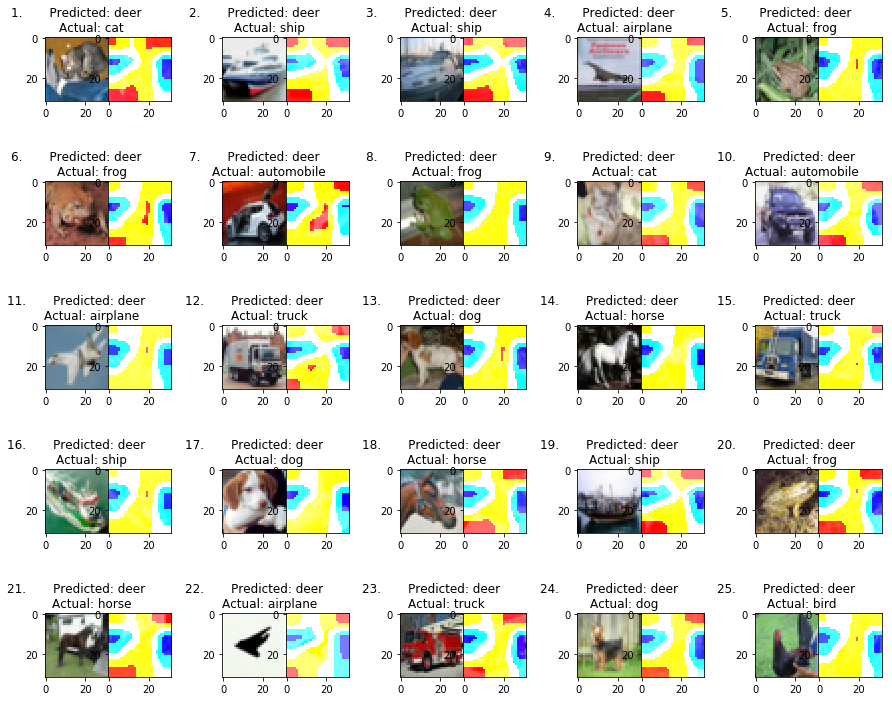

In [21]:
plot_figures(figures, 5, 5)

# 150 epochs

In [0]:
class showLR( Callback ) :
    """
    Callbacks to show learning rate and time elapsed from 1st epoch
    """
    time = time.time()
    
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
          self.time = time.time()
          
          print("time registered", self.time)
          
        current_time = time.time()
        
        time_taken = current_time - self.time
        lr = float(K.get_value(self.model.optimizer.lr))
        
        if epoch % 10 == 0:
          print(" epoch={:02d}, lr={:.5f}, time_elapsed(s)={:.2f}".format( epoch, lr, time_taken))

reshaping via a convolution...
reshaping via a convolution...
time registered 1564537542.6286383
 epoch=00, lr=0.02400, time_elapsed(s)=0.00
 - lr: 0.03722 - momentum: 0.95 
 - lr: 0.05048 - momentum: 0.95 
 - lr: 0.06374 - momentum: 0.94 
 - lr: 0.07699 - momentum: 0.94 
 - lr: 0.09025 - momentum: 0.94 
 - lr: 0.10351 - momentum: 0.94 
 - lr: 0.11677 - momentum: 0.94 
 - lr: 0.13002 - momentum: 0.93 
 - lr: 0.14328 - momentum: 0.93 
 - lr: 0.15654 - momentum: 0.93 
 epoch=10, lr=0.15657, time_elapsed(s)=558.95
 - lr: 0.16979 - momentum: 0.93 
 - lr: 0.18305 - momentum: 0.93 
 - lr: 0.19631 - momentum: 0.93 
 - lr: 0.20957 - momentum: 0.92 
 - lr: 0.22282 - momentum: 0.92 
 - lr: 0.23608 - momentum: 0.92 
 - lr: 0.24934 - momentum: 0.92 
 - lr: 0.26259 - momentum: 0.92 
 - lr: 0.27585 - momentum: 0.91 
 - lr: 0.28911 - momentum: 0.91 
 epoch=20, lr=0.28914, time_elapsed(s)=1101.37
 - lr: 0.30237 - momentum: 0.91 
 - lr: 0.31562 - momentum: 0.91 
 - lr: 0.32888 - momentum: 0.91 
 - lr: 

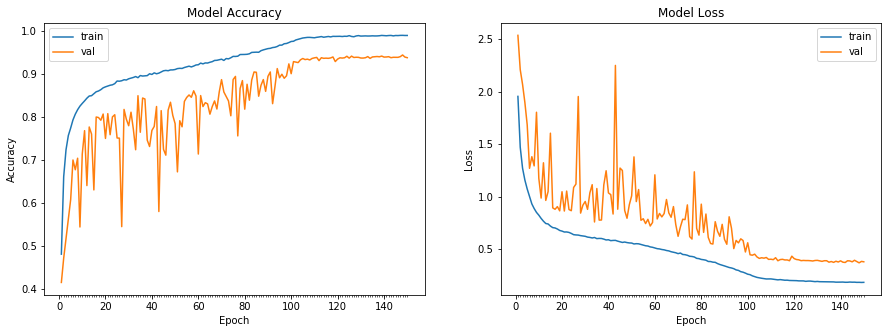

Accuracy on test data is: 93.89


In [23]:
epochs = 150

lr_manager = OneCycleLR( max_lr = max_lr, batch_size = bs, samples = train_features.shape[0],
                        end_percentage=end_percentage, scale_percentage=None,
                        maximum_momentum=max_m, minimum_momentum=base_m)

filepath = "assignment_13_150epochs_eva.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

sgd = optimizers.SGD(lr=base_lr,  momentum=0.9, decay=decayrate)

showlr = showLR()

model = resnet.ResNet18((train_features.shape[1], train_features.shape[2], train_features.shape[3]), 10)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()

test_iterator = datagen_test.flow(test_features, test_labels, batch_size = bs, shuffle = False)

model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = bs),
                                 samples_per_epoch = int(train_features.shape[0]), nb_epoch = epochs, 
                                 validation_data = test_iterator,
                                 validation_steps = len(test_iterator),
                                 callbacks=[checkpoint, lr_manager, showlr] ,verbose=0)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

model.load_weights(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_iterator, model))


In [24]:
num_aug_images_tta = 15

tta_acc_150 = tta_accuracy(model, test_features, test_labels,  datagen_test, num_aug_images = num_aug_images_tta)

print("Accuracy on test data using test time augmentation is: %0.2f"%tta_acc_150)

Accuracy on test data using test time augmentation is: 0.95
